In [1]:
import tensorflow as tf
import tensorflow.keras as keras
from tqdm import tqdm
import cv2
import numpy as np
import pydot

In [2]:
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,roc_curve,auc


from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16,preprocess_input
from keras.layers import Dense,Flatten,Dropout,Concatenate,GlobalAveragePooling2D,Lambda,ZeroPadding2D
from keras.layers import SeparableConv2D,BatchNormalization,MaxPooling2D,Conv2D
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

In [3]:
%matplotlib inline
import pandas as pd
import os,shutil,math,scipy,cv2
import numpy as np
import matplotlib.pyplot as plt
import random as rn


from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,roc_curve,auc

from PIL import Image
from PIL import Image as pil_image
from PIL import ImageDraw

from time import time
from glob import glob
from tqdm import tqdm
from skimage.io import imread
from IPython.display import SVG

from scipy import misc,ndimage
from scipy.ndimage.interpolation import zoom


from keras import backend as K
from keras.utils.np_utils import to_categorical
from keras import layers
from keras.preprocessing.image import save_img
from keras.utils.vis_utils import model_to_dot
from keras.applications.vgg16 import VGG16,preprocess_input
from keras.applications.xception import Xception
from keras.applications.nasnet import NASNetMobile
from keras.models import Sequential,Input,Model
from keras.layers import Dense,Flatten,Dropout,Concatenate,GlobalAveragePooling2D,Lambda,ZeroPadding2D
from keras.layers import SeparableConv2D,BatchNormalization,MaxPooling2D,Conv2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam,SGD
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard,CSVLogger,ReduceLROnPlateau,LearningRateScheduler

In [4]:
from os import listdir
from os.path import isfile, join
DATA_PATH = 'data/images'

In [5]:
classes = listdir(DATA_PATH)
print(len(classes))

120


In [6]:
stats = []
for each in classes:
    train_count = len(listdir(join(DATA_PATH, each)))
    stats.append([train_count, each])

In [7]:
stats.sort()

In [8]:
stats[-8:]

[[214, 'n02086240-Shih-Tzu'],
 [218, 'n02090721-Irish_wolfhound'],
 [218, 'n02107683-Bernese_mountain_dog'],
 [218, 'n02111889-Samoyed'],
 [219, 'n02112018-Pomeranian'],
 [232, 'n02092002-Scottish_deerhound'],
 [239, 'n02088094-Afghan_hound'],
 [252, 'n02085936-Maltese_dog']]

In [9]:
shortlisted = ['n02085620-Chihuahua', 'n02085782-Japanese_spaniel', 'n02085936-Maltese_dog', 'n02086079-Pekinese', 'n02086240-Shih-Tzu','n02086646-Blenheim_spaniel','n02086910-papillon','n02087046-toy_terrier','n02088094-Afghan_hound','n02088238-basset']

In [10]:
X = []
Z = []
imgsize = 150

In [11]:
def training_data(label,data_dir):
    for img in tqdm(listdir(data_dir)):
        path = join(data_dir,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img,(imgsize,imgsize))
        
        X.append(np.array(img))
        Z.append(str(label))

In [12]:
paths=[]

for index, dog in enumerate(shortlisted):
    path = join(DATA_PATH, dog)
    images = listdir(path)
    label = dog.split('-')[-1]
    training_data(label, path)

100%|███████████████████████████████████████████████████████████████████████████████| 175/175 [00:01<00:00, 133.60it/s]


In [13]:
X = np.array(X)

In [14]:
X = X/255

In [15]:
label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(Z)
Y = to_categorical(Y, len(shortlisted))

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=0)

In [17]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1441, 150, 150, 3) (1441, 10)
(481, 150, 150, 3) (481, 10)


In [18]:
img_gen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False, 
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=10,  
        zoom_range = 0.1, 
        width_shift_range=0.2,  
        height_shift_range=0.2, 
        horizontal_flip=True,  
        vertical_flip=False) 

img_gen.fit(X_train)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x0000026256EEF580> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000026259ADCAF0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000002629E7E2310> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x0000026259ADCF70> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000002629E83B580> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000002629E83B610> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x000002629E838100> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000002629E869FD0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000002629E8691F0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000002629E8644F0> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x000002629E85D790> False
<tensorflow.python.

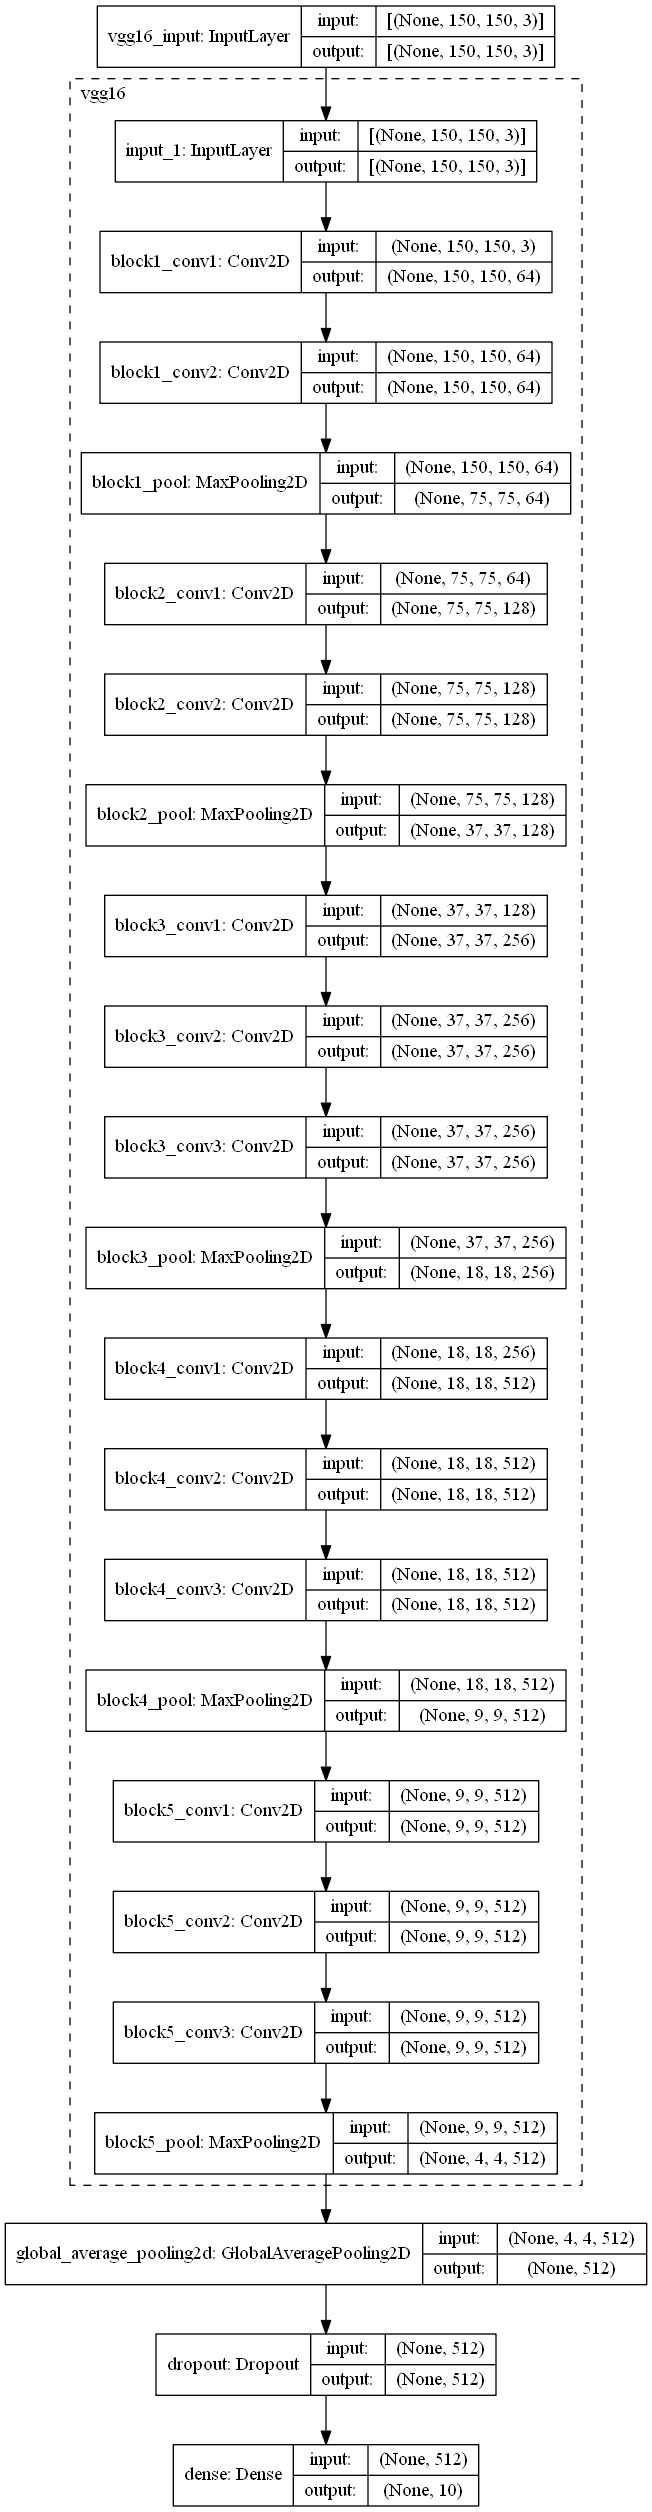

In [19]:
base_model = VGG16(include_top=False,
                  input_shape = (imgsize,imgsize,3),
                  weights = 'imagenet')

for layer in base_model.layers:
    layer.trainable = False
    
for layer in base_model.layers:
    print(layer,layer.trainable)

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(len(shortlisted),activation='softmax'))
model.summary()

SVG(model_to_dot(model).create(prog='dot', format='svg'))
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, expand_nested=True)

In [22]:
checkpoint = ModelCheckpoint(
    './base.model',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    save_weights_only=False,
    period=1
)
earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=30,
    verbose=1,
    mode='auto'
)
tensorboard = TensorBoard(
    log_dir = './logs',
    histogram_freq=0,
    batch_size=16,
    write_graph=True,
    write_grads=True,
    write_images=False,
)

csvlogger = CSVLogger(
    filename= "training_csv.log",
    separator = ",",
    append = False
)

reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1, 
    mode='auto'
)

callbacks = [checkpoint,tensorboard,csvlogger,reduce]

In [28]:
#-----------Optimizers-----------#
opt = SGD(lr=1e-4,momentum=0.99)
opt1 = Adam(lr=1e-2)
#----------Compile---------------#
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
#-----------Training------------#
history = model.fit_generator(
    img_gen.flow(X_train,y_train,batch_size=16),
    validation_data  = (X_test,y_test),
    validation_steps = 20,
    steps_per_epoch  =20,
    epochs = 25,
    verbose = 1,
    callbacks=callbacks
)

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/25
20/20 [==============================] - 22s 1s/step - loss: 1.6940 - accuracy: 0.4217 - val_loss: 1.5113 - val_accuracy: 0.5884

Epoch 00001: val_loss improved from 1.55129 to 1.51129, saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets
Epoch 2/25
20/20 [==============================] - 19s 987ms/step - loss: 1.6705 - accuracy: 0.4144 - val_loss: 1.5018 - val_accuracy: 0.5904

Epoch 00002: val_loss improved from 1.51129 to 1.50177, saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets
Epoch 3/25
20/20 [==============================] - 19s 992ms/step - loss: 1.6648 - accuracy: 0.4167 - val_loss: 1.4838 - val_accuracy: 0.6071

Epoch 00003: val_loss improved from 1.50177 to 1.48381, saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets
Epoch 4/25
20/20 [==============================] - 19s 983ms/step - loss: 1.7052 - accuracy: 0.4573 - val_loss: 1.4713 - val_accuracy: 0.5967

Epoch 0

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x00000262C3D5BF40> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000262A8259460> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000262A8AB8FD0> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x00000262C3D5BDF0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000262C6DAFD30> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000262A86DE220> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x00000262A9B24460> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000262A8AADD90> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000262C3BC6CA0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000262C38B8EB0> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x00000262A8B5B220> False
<tensorflow.python.

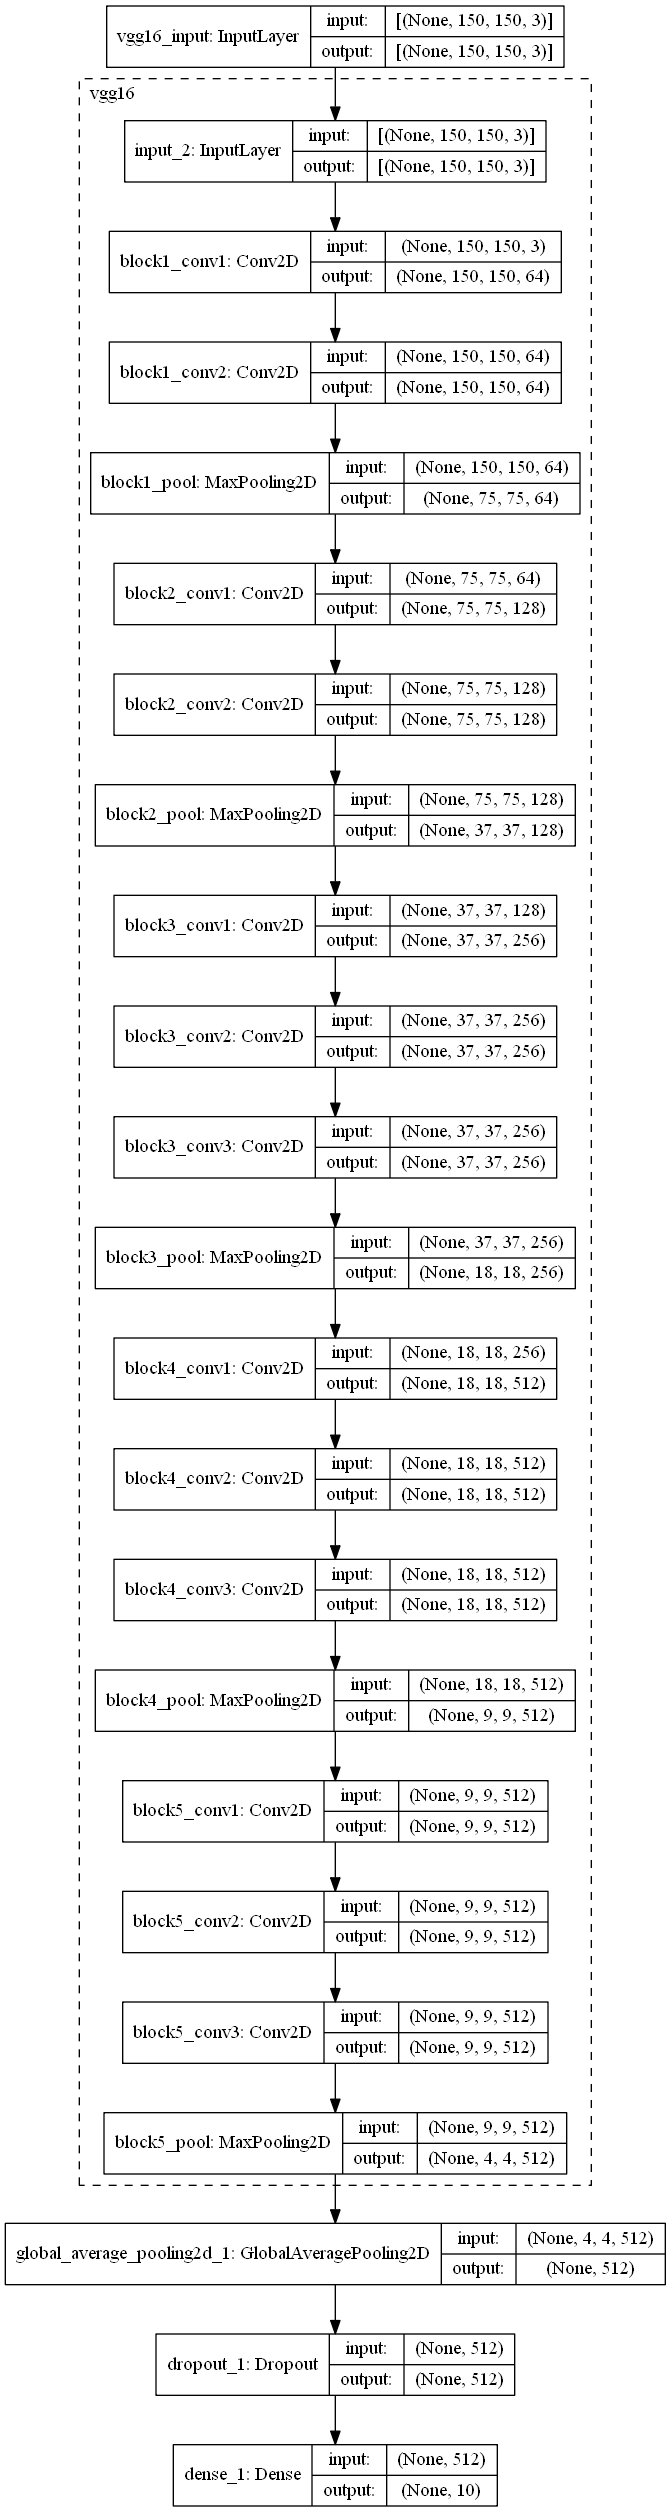

In [29]:
base_model1 = VGG16(include_top=False,
                  input_shape = (imgsize,imgsize,3),
                  weights = 'imagenet')

for layer in base_model1.layers[:-1]:
    layer.trainable = False
    
for layer in base_model1.layers:
    print(layer,layer.trainable)

model1 = Sequential()
model1.add(base_model1)
model1.add(GlobalAveragePooling2D())
model1.add(Dropout(0.5))
model1.add(Dense(len(shortlisted),activation='softmax'))
model1.summary()

SVG(model_to_dot(model1).create(prog='dot', format='svg'))
plot_model(model1, to_file='model_plot.png', show_shapes=True, show_layer_names=True, expand_nested=True)

In [30]:
checkpoint = ModelCheckpoint(
    './base.model',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    save_weights_only=False,
    period=1
)
earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=30,
    verbose=1,
    mode='auto'
)
tensorboard = TensorBoard(
    log_dir = './logs',
    histogram_freq=0,
    batch_size=16,
    write_graph=True,
    write_grads=True,
    write_images=False,
)

csvlogger = CSVLogger(
    filename= "training_csv.log",
    separator = ",",
    append = False
)

reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1, 
    mode='auto'
)

callbacks = [checkpoint,tensorboard,csvlogger,reduce]

In [32]:
#-----------Optimizers-----------#
opt = SGD(lr=1e-4,momentum=0.99)
opt1 = Adam(lr=1e-2)
#----------Compile---------------#
model1.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
#-----------Training------------#
history = model1.fit_generator(
    img_gen.flow(X_train,y_train,batch_size=16),
    validation_data  = (X_test,y_test),
    validation_steps = 20,
    steps_per_epoch  = 20 ,
    epochs = 25,
    verbose = 1,
    callbacks=callbacks
)

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/25
20/20 [==============================] - 22s 1s/step - loss: 2.3404 - accuracy: 0.1810 - val_loss: 2.1031 - val_accuracy: 0.2931

Epoch 00001: val_loss improved from 2.21364 to 2.10309, saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets
Epoch 2/25
20/20 [==============================] - 20s 1s/step - loss: 2.2023 - accuracy: 0.1921 - val_loss: 2.0557 - val_accuracy: 0.3430

Epoch 00002: val_loss improved from 2.10309 to 2.05571, saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets
Epoch 3/25
20/20 [==============================] - 20s 1s/step - loss: 2.1358 - accuracy: 0.2562 - val_loss: 2.0079 - val_accuracy: 0.3597

Epoch 00003: val_loss improved from 2.05571 to 2.00791, saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets
Epoch 4/25
20/20 [==============================] - 19s 1s/step - loss: 2.1840 - accuracy: 0.2061 - val_loss: 1.9657 - val_accuracy: 0.4387

Epoch 00004: val

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x00000262A90F4160> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000262C736C5B0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000262A807BBE0> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x00000262A95E52B0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000262A95A4490> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000262A9508D00> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x00000262C3CCD5E0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000262C69A9E20> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000262C6A254F0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000262A95A4AC0> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x00000262C6F950D0> False
<tensorflow.python.

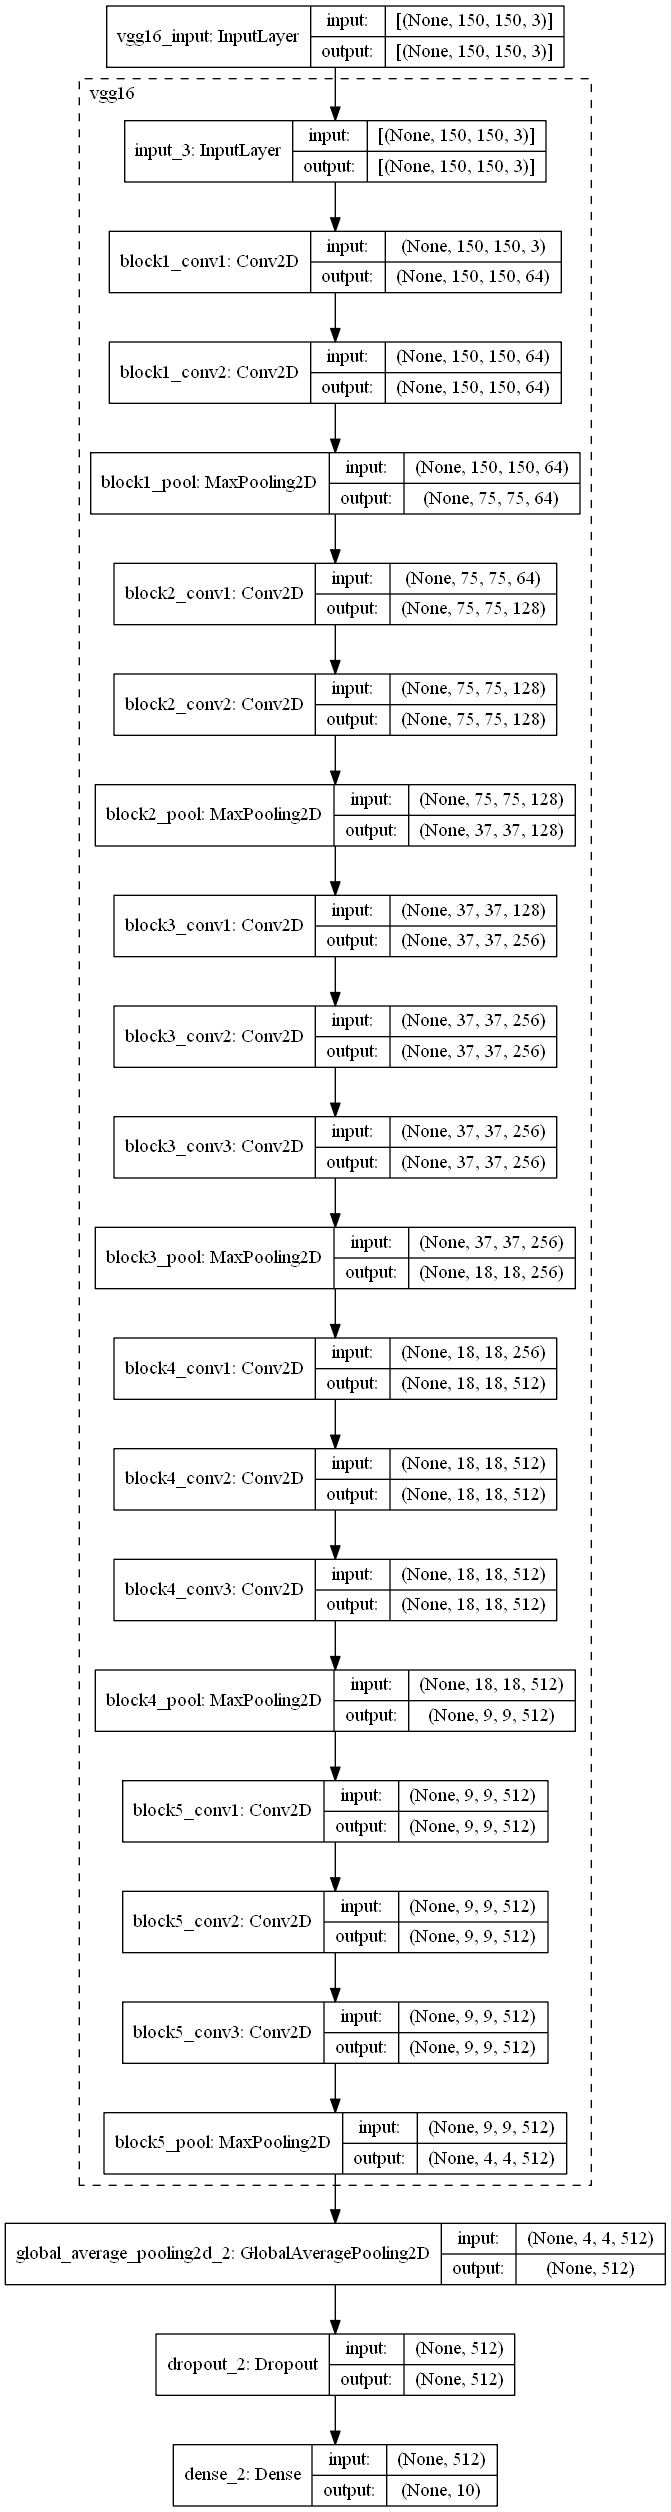

In [33]:
base_model2 = VGG16(include_top=False,
                  input_shape = (imgsize,imgsize,3),
                  weights = 'imagenet')

for layer in base_model2.layers[:-2]:
    layer.trainable = False
    
for layer in base_model2.layers:
    print(layer,layer.trainable)

model2 = Sequential()
model2.add(base_model2)
model2.add(GlobalAveragePooling2D())
model2.add(Dropout(0.5))
model2.add(Dense(len(shortlisted),activation='softmax'))
model2.summary()

SVG(model_to_dot(model2).create(prog='dot', format='svg'))
plot_model(model2, to_file='model_plot.png', show_shapes=True, show_layer_names=True, expand_nested=True)

In [34]:
checkpoint = ModelCheckpoint(
    './base.model2',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    save_weights_only=False,
    period=1
)
earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=30,
    verbose=1,
    mode='auto'
)
tensorboard = TensorBoard(
    log_dir = './logs',
    histogram_freq=0,
    batch_size=16,
    write_graph=True,
    write_grads=True,
    write_images=False,
)

csvlogger = CSVLogger(
    filename= "training_csv.log",
    separator = ",",
    append = False
)

reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1, 
    mode='auto'
)

callbacks = [checkpoint,tensorboard,csvlogger,reduce]

In [35]:
#-----------Optimizers-----------#
opt = SGD(lr=1e-4,momentum=0.99)
opt1 = Adam(lr=1e-2)
#----------Compile---------------#
model2.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
#-----------Training------------#
history = model2.fit_generator(
    img_gen.flow(X_train,y_train,batch_size=16),
    validation_data  = (X_test,y_test),
    validation_steps = 20,
    steps_per_epoch  = 20 ,
    epochs = 25,
    verbose = 1,
    callbacks=callbacks
)

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/25
20/20 [==============================] - 24s 1s/step - loss: 2.9029 - accuracy: 0.1384 - val_loss: 1.9219 - val_accuracy: 0.3701

Epoch 00001: val_loss improved from inf to 1.92188, saving model to .\base.model2
INFO:tensorflow:Assets written to: .\base.model2\assets
Epoch 2/25
20/20 [==============================] - 21s 1s/step - loss: 2.0049 - accuracy: 0.2753 - val_loss: 1.6283 - val_accuracy: 0.4740

Epoch 00002: val_loss improved from 1.92188 to 1.62825, saving model to .\base.model2
INFO:tensorflow:Assets written to: .\base.model2\assets
Epoch 3/25
20/20 [==============================] - 21s 1s/step - loss: 1.8451 - accuracy: 0.3337 - val_loss: 1.4265 - val_accuracy: 0.5364

Epoch 00003: val_loss improved from 1.62825 to 1.42653, saving model to .\base.model2
INFO:tensorflow:Assets written to: .\base.model2\assets
Epoch 4/25
20/20 [==============================] - 21s 1s/step - loss: 1.5763 - accuracy: 0.4260 - val_loss: 1.3595 - val_accuracy: 0.5759

Epoch 00004: v

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x00000262C4357610> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000262E2C65D90> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000262C3899C70> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x00000262C39E22B0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000262C42F19D0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000262A953B2E0> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x00000262C42F1490> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000262A748C910> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000262C41470D0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000262C9285E80> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x00000262A89492E0> False
<tensorflow.python.

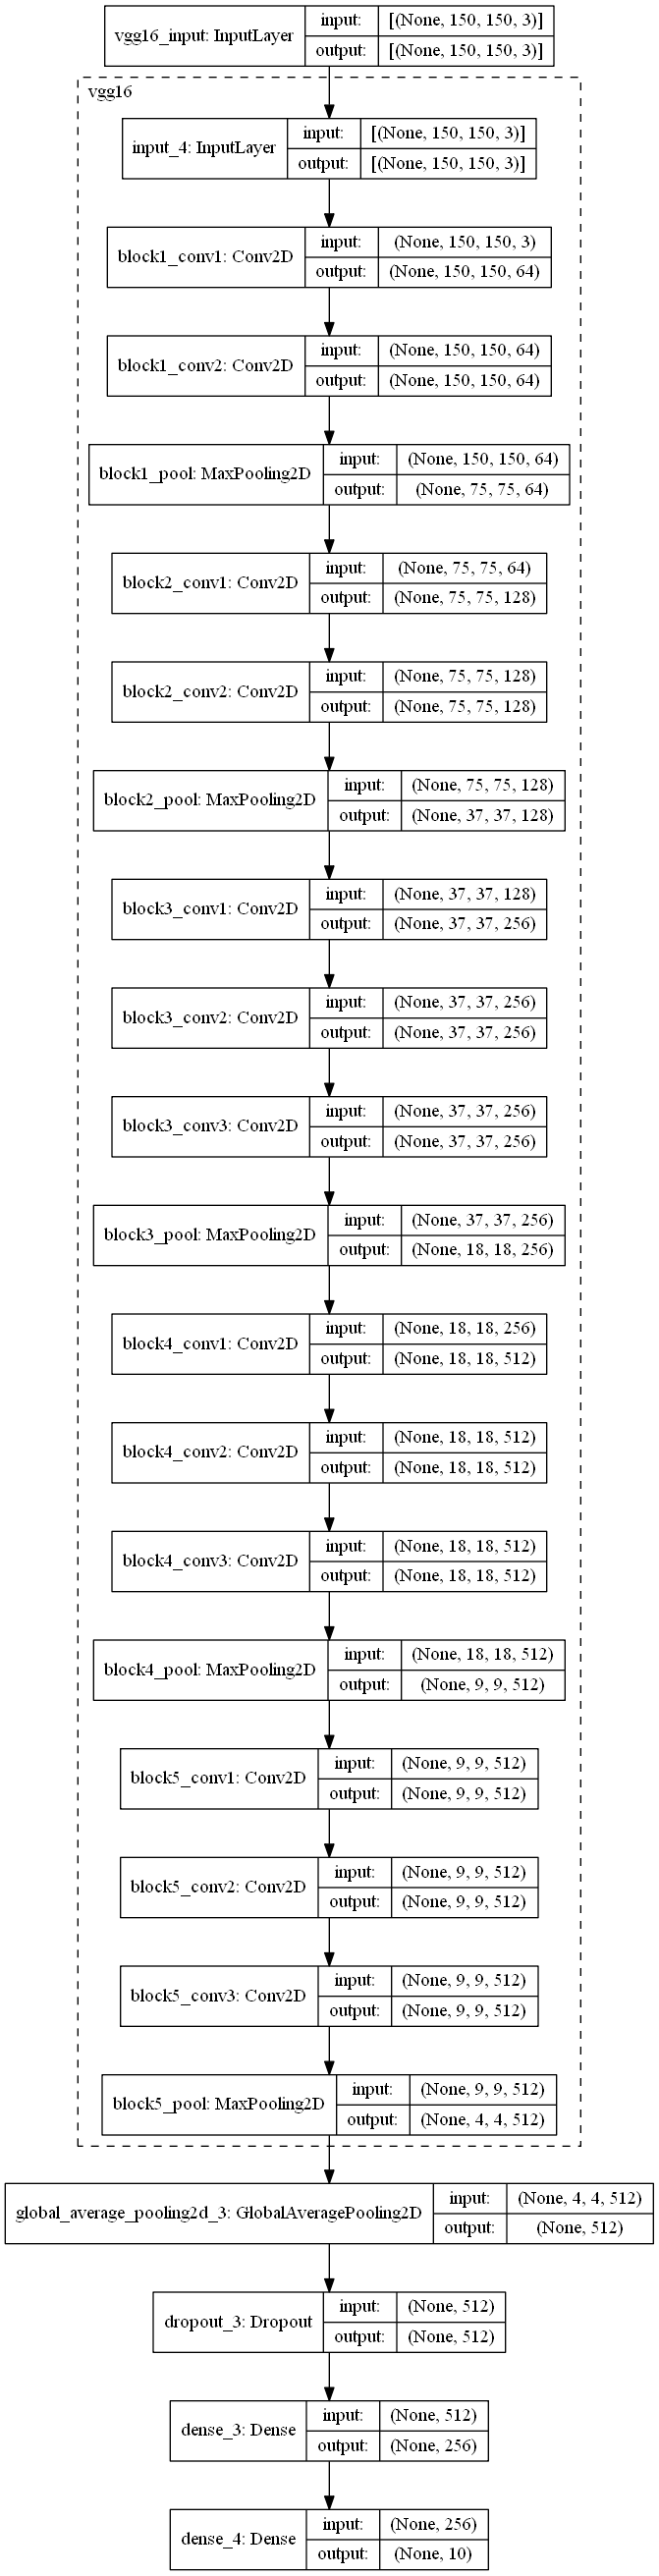

In [36]:
base_model3 = VGG16(include_top=False,
                  input_shape = (imgsize,imgsize,3),
                  weights = 'imagenet')

for layer in base_model3.layers[:-2]:
    layer.trainable = False
    
for layer in base_model3.layers:
    print(layer,layer.trainable)

model3= Sequential()
model3.add(base_model3)
model3.add(GlobalAveragePooling2D())
model3.add(Dropout(0.5))
model3.add(Dense(256,activation='relu'))
model3.add(Dense(len(shortlisted),activation='softmax'))
model3.summary()

SVG(model_to_dot(model3).create(prog='dot', format='svg'))
plot_model(model3, to_file='model_plot.png', show_shapes=True, show_layer_names=True, expand_nested=True)

In [37]:
checkpoint = ModelCheckpoint(
    './base.model2',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    save_weights_only=False,
    period=1
)
earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=30,
    verbose=1,
    mode='auto'
)
tensorboard = TensorBoard(
    log_dir = './logs',
    histogram_freq=0,
    batch_size=16,
    write_graph=True,
    write_grads=True,
    write_images=False,
)

csvlogger = CSVLogger(
    filename= "training_csv.log",
    separator = ",",
    append = False
)

reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1, 
    mode='auto'
)

callbacks = [checkpoint,tensorboard,csvlogger,reduce]

In [38]:
#-----------Optimizers-----------#
opt = SGD(lr=1e-4,momentum=0.99)
opt1 = Adam(lr=1e-2)
#----------Compile---------------#
model3.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
#-----------Training------------#
history = model3.fit_generator(
    img_gen.flow(X_train,y_train,batch_size=16),
    validation_data  = (X_test,y_test),
    validation_steps = 20,
    steps_per_epoch  = 20 ,
    epochs = 25,
    verbose = 1,
    callbacks=callbacks
)

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/25
20/20 [==============================] - 23s 1s/step - loss: 2.6797 - accuracy: 0.1467 - val_loss: 2.0222 - val_accuracy: 0.2952

Epoch 00001: val_loss improved from inf to 2.02221, saving model to .\base.model2
INFO:tensorflow:Assets written to: .\base.model2\assets
Epoch 2/25
20/20 [==============================] - 20s 1s/step - loss: 2.1676 - accuracy: 0.2568 - val_loss: 1.6834 - val_accuracy: 0.4657

Epoch 00002: val_loss improved from 2.02221 to 1.68339, saving model to .\base.model2
INFO:tensorflow:Assets written to: .\base.model2\assets
Epoch 3/25
20/20 [==============================] - 20s 1s/step - loss: 1.8926 - accuracy: 0.3081 - val_loss: 1.5707 - val_accuracy: 0.4886

Epoch 00003: val_loss improved from 1.68339 to 1.57070, saving model to .\base.model2
INFO:tensorflow:Assets written to: .\base.model2\assets
Epoch 4/25
20/20 [==============================] - 20s 1s/step - loss: 1.7945 - accuracy: 0.3740 - val_loss: 1.4050 - val_accuracy: 0.5426

Epoch 00004: v

In [109]:
test_img = 'data/spaniel.jpg'

path = test_img
img = cv2.imread(path,cv2.IMREAD_COLOR)
img = cv2.resize(img,(imgsize,imgsize))

test_img = np.array(img)
test_img = test_img/255

In [110]:
predict = [np.argmax(model.predict(test_img.reshape(-1, 150, 150, 3)))]
label_encoder.inverse_transform(predict)

array(['Blenheim_spaniel'], dtype='<U16')

In [111]:
predict = [np.argmax(model1.predict(test_img.reshape(-1, 150, 150, 3)))]
label_encoder.inverse_transform(predict)

array(['Blenheim_spaniel'], dtype='<U16')

In [112]:
predict = [np.argmax(model2.predict(test_img.reshape(-1, 150, 150, 3)))]
label_encoder.inverse_transform(predict)

array(['Blenheim_spaniel'], dtype='<U16')

In [113]:
predict = [np.argmax(model3.predict(test_img.reshape(-1, 150, 150, 3)))]
label_encoder.inverse_transform(predict)

array(['Blenheim_spaniel'], dtype='<U16')

In [108]:
Y

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [65]:
shortlisted

['n02085620-Chihuahua',
 'n02085782-Japanese_spaniel',
 'n02085936-Maltese_dog',
 'n02086079-Pekinese',
 'n02086240-Shih-Tzu',
 'n02086646-Blenheim_spaniel',
 'n02086910-papillon',
 'n02087046-toy_terrier',
 'n02088094-Afghan_hound',
 'n02088238-basset']

In [78]:
X

array([[[[0.05098039, 0.03137255, 0.03921569],
         [0.03921569, 0.01960784, 0.02352941],
         [0.03137255, 0.02745098, 0.01176471],
         ...,
         [0.32156863, 0.50980392, 0.39607843],
         [0.49803922, 0.67843137, 0.57254902],
         [0.4745098 , 0.63921569, 0.55294118]],

        [[0.04313725, 0.03137255, 0.03921569],
         [0.04705882, 0.03921569, 0.03921569],
         [0.03529412, 0.03137255, 0.02745098],
         ...,
         [0.18823529, 0.43137255, 0.34117647],
         [0.18039216, 0.43921569, 0.34901961],
         [0.23921569, 0.50980392, 0.41960784]],

        [[0.03137255, 0.03137255, 0.03137255],
         [0.03921569, 0.04313725, 0.03529412],
         [0.02352941, 0.03529412, 0.02745098],
         ...,
         [0.10588235, 0.40784314, 0.34117647],
         [0.08627451, 0.41960784, 0.34117647],
         [0.09803922, 0.45490196, 0.36078431]],

        ...,

        [[1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ]

In [84]:
y_classes = [np.argmax(y, axis=None, out=None) for y in Y]

In [85]:
y_classes

[2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,


In [81]:
shortlisted

['n02085620-Chihuahua',
 'n02085782-Japanese_spaniel',
 'n02085936-Maltese_dog',
 'n02086079-Pekinese',
 'n02086240-Shih-Tzu',
 'n02086646-Blenheim_spaniel',
 'n02086910-papillon',
 'n02087046-toy_terrier',
 'n02088094-Afghan_hound',
 'n02088238-basset']

In [87]:
Z

['Chihuahua',
 'Chihuahua',
 'Chihuahua',
 'Chihuahua',
 'Chihuahua',
 'Chihuahua',
 'Chihuahua',
 'Chihuahua',
 'Chihuahua',
 'Chihuahua',
 'Chihuahua',
 'Chihuahua',
 'Chihuahua',
 'Chihuahua',
 'Chihuahua',
 'Chihuahua',
 'Chihuahua',
 'Chihuahua',
 'Chihuahua',
 'Chihuahua',
 'Chihuahua',
 'Chihuahua',
 'Chihuahua',
 'Chihuahua',
 'Chihuahua',
 'Chihuahua',
 'Chihuahua',
 'Chihuahua',
 'Chihuahua',
 'Chihuahua',
 'Chihuahua',
 'Chihuahua',
 'Chihuahua',
 'Chihuahua',
 'Chihuahua',
 'Chihuahua',
 'Chihuahua',
 'Chihuahua',
 'Chihuahua',
 'Chihuahua',
 'Chihuahua',
 'Chihuahua',
 'Chihuahua',
 'Chihuahua',
 'Chihuahua',
 'Chihuahua',
 'Chihuahua',
 'Chihuahua',
 'Chihuahua',
 'Chihuahua',
 'Chihuahua',
 'Chihuahua',
 'Chihuahua',
 'Chihuahua',
 'Chihuahua',
 'Chihuahua',
 'Chihuahua',
 'Chihuahua',
 'Chihuahua',
 'Chihuahua',
 'Chihuahua',
 'Chihuahua',
 'Chihuahua',
 'Chihuahua',
 'Chihuahua',
 'Chihuahua',
 'Chihuahua',
 'Chihuahua',
 'Chihuahua',
 'Chihuahua',
 'Chihuahua',
 'Chih